In [2]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.signal as sgn

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [3]:
from pathlib import Path
import json

In [16]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [17]:
DIRS['RAW_DATA'] = '/data/dudyrev/Speach_Synthesizer/raw_data/'

In [6]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Functions

In [98]:
def align_file(path_txt):
    if isinstance(path_txt, Path):
        path_txt = path_txt.as_posix()
    path_align = path_txt.replace('.txt','.align')
    if os.path.isfile(path_align):
        return 2, path_align
    
    path_wav = path_txt.replace('.txt', '.wav')
    if not os.path.isfile(path_wav):
        return 3, path_wav
    
    try:
        with open(path_txt, 'rb') as f:
            txt = f.read().strip().decode()
        
        tf.reset_default_graph()
        audio = sl.load_audio_not_one_hot(path_wav)
        with tf.Session() as sess:
            init_variables = tf.global_variables_initializer()
            sess.run(init_variables)
            audio_ev = audio.eval(session=sess)

        audio_ev_norm, audio_roll, lim, m = sl.align_audio(audio_ev, txt, window_size=1000)
        if m is None:
            path_align = None
        else:
            with open(path_align, 'wb') as f:
                np.save(f,m)
        return 1, path_align
    except Exception as e:
        print(e)
        return 0, None
    
    return 1, path_align

# Voxforge text

In [8]:
dir_ = (DIRS['RAW_DATA']+'rus').replace('//','/')
dir_

'/data/dudyrev/Speach_Synthesizer/raw_data/rus'

In [24]:
files_ds = pd.concat([pd.read_csv(DIRS['MANIFESTS']+f, names=['wav','txt','dur']) for f in os.listdir(DIRS['MANIFESTS'])])

In [25]:
files_ds.shape

(3387428, 3)

In [26]:
files_ds.head()

,wav,txt,dur
0,../data/ru_open_stt/public_youtube700/f/47/0b1...,../data/ru_open_stt/public_youtube700/f/47/0b1...,0.5
1,../data/ru_open_stt/public_youtube700/8/c8/736...,../data/ru_open_stt/public_youtube700/8/c8/736...,0.5
2,../data/ru_open_stt/public_youtube700/1/1d/446...,../data/ru_open_stt/public_youtube700/1/1d/446...,0.5
3,../data/ru_open_stt/public_youtube700/8/5d/a7e...,../data/ru_open_stt/public_youtube700/8/5d/a7e...,0.5
4,../data/ru_open_stt/public_youtube700/7/5b/b97...,../data/ru_open_stt/public_youtube700/7/5b/b97...,0.5


In [51]:
files_ds['wav'] = files_ds['wav'].apply(lambda f: f.replace('../data/ru_open_stt',DIRS['RAW_DATA']+'rus') if f is not None else None)
files_ds['txt'] = files_ds['txt'].apply(lambda f: f.replace('../data/ru_open_stt',DIRS['RAW_DATA']+'rus') if f is not np.nan else None)

In [55]:
files_ds['wav_exist'] = files_ds['wav'].apply(lambda f: os.path.isfile(f) if f is not None else False)
files_ds['txt_exist'] = files_ds['txt'].apply(lambda f: os.path.isfile(f) if f is not None else False)

In [81]:
files_ds.index = range(len(files_ds))
files_ds['id'] = files_ds.index

In [85]:
files_ds.to_csv(DIRS['MANIFESTS']+'/total.csv')

In [125]:
result = list(Path(dir_).rglob("*.align"))
res_len = len(list(result))

In [126]:
res_len

3818

In [124]:
files_ds.index = files_ds['wav']

In [115]:
to_align_ds.index = to_align_ds['wav']

In [129]:
for fname in tqdm_notebook(result,total=res_len):
    fname = fname.as_posix()
    files_ds.at[fname.replace('.align','.wav'),'align'] = fname

HBox(children=(IntProgress(value=0, max=3818), HTML(value='')))

In [130]:
files_ds.index = files_ds['id']

In [132]:
files_ds['align_exist'] = -files_ds['align'].isna()

In [133]:
files_ds.to_csv(DIRS['MANIFESTS']+'/total.csv')

In [134]:
files_ds.head()

,wav,txt,dur,wav_exist,txt_exist,id,align,align_exist
id,,,,,,,,
0,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,0.5,False,False,0,NaN,False
1,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,0.5,False,False,1,NaN,False
2,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,0.5,False,False,2,NaN,False
3,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,0.5,False,False,3,NaN,False
4,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,/data/dudyrev/Speach_Synthesizer/raw_data/rus/...,0.5,False,False,4,NaN,False


In [135]:
to_align_ds = files_ds[(files_ds['wav_exist'])&(files_ds['txt_exist'])&(-files_ds['align_exist'])]

In [136]:
to_align_ds.shape, files_ds.shape, to_align_ds.shape[0]/files_ds.shape[0]

((928434, 8), (3387428, 8), 0.2740822830773082)

In [ ]:
n = 100
i = 0
for idx, path in tqdm_notebook(to_align_ds['txt'].iteritems(), total=len(to_align_ds)):
    res, fname = align_file(path)
    files_ds.loc[idx,'align'] = fname
    files_ds.loc[idx,'align_exist'] = True if fname is not None else None
    i += 1
    if i%n==0:
        files_ds.to_csv(DIRS['MANIFESTS']+'/total.csv')

In [26]:
with open('/data/dudyrev/Speach_Synthesizer/raw_data/rus/private_buriy_audiobooks_2/6/ee/2e1edfbb1f87.align','rb') as f:
    t = np.load(f)

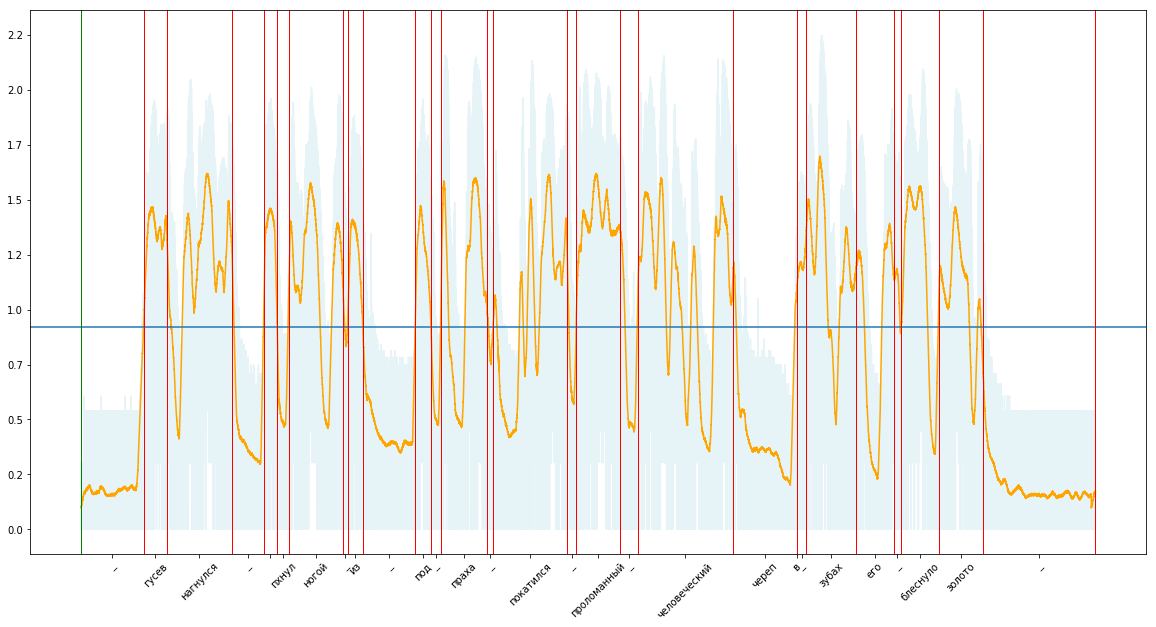

In [20]:
plt.figure(figsize=(20,10))
sl.plot_audio(audio_ev_norm, audio_roll, lim, m, ' '.join([c.replace(' ','_') for c in m[:,0]]))

# Maximum text characteristics

In [1586]:
chars = set()
max_text_len = 0
max_word_len = 0
max_words_in_text = 0
for fname in tqdm_notebook(txt_fnames):
    with open(fname, 'rb') as f:
        t = f.read().decode().strip()
    [chars.add(x) for x in t];
    max_text_len = max(max_text_len, len(t))
    max_word_len = max(max_word_len,max([len(x) for x in t.split(' ')]))
    max_words_in_text = max(max_words_in_text,len(t.split(' ')))

In [1587]:
max_text_len, max_word_len, max_words_in_text, len(chars)

(210, 20, 33, 34)

In [86]:
max_text_len = 210
max_word_len = 35 #20
max_words_in_text = 33

In [1588]:
211*35

7385

# Add text to Input features

In [21]:
char_to_int = {k: idx for idx,k in enumerate('\0 абвгдежзийклмнопрстуфхцчшщъыьэюяё')}

In [70]:
fname_wav, fname_txt, fname_align = text_ds.loc[0,['wav','txt','align']]
fname_wav

'/opt/notebooks/raw_data/rus/voxforge_ru/a/40/d5bd4d55f3d8.wav'

In [71]:
data = sl.load_data([fname_wav])

In [72]:
oh = sl.load_text_oh([fname_align])

In [73]:
sl.get_train_test(data, batch_size=10, truncated_len=100, text_oh=oh)

(<tf.Tensor 'concat_59:0' shape=(10, 100, 1228) dtype=float64>,
 <tf.Tensor 'concat_60:0' shape=(10, 100, 2) dtype=float64>,
 <tf.Tensor 'concat_64:0' shape=(10, 100, 1228) dtype=float64>,
 <tf.Tensor 'concat_65:0' shape=(10, 100, 2) dtype=float64>)

In [65]:
data

<tf.Tensor 'X_data_1:0' shape=(1, 25988, 2) dtype=float64>

In [66]:
oh

<tf.Tensor 'Reshape_7:0' shape=(1, 25989, 1225) dtype=float64>

In [57]:
sl.generate_batch(data, 10, 100, text_oh=)

TypeError: generate_batch() missing 2 required positional arguments: 'batch_size' and 'truncated_len'